In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization, Dense
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import tensorflow as tf

import sys, os
import pandas as pd
import numpy as np
import cv2
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
# Create a ZipFile Object and load sample.zip in it\
from zipfile import ZipFile 
with ZipFile('/content/drive/My Drive/fer2013.zip', 'r') as zipObj:
# Extract all the contents of zip file in current directory
    zipObj.extractall()

In [ ]:
#Loading FER Data-set

dataset_path = "/content/fer2013.csv"
image_size=(48,48)
 
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist() #Converting the relevant column element into a list for each row
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')] #Splitting the string by space character as a list
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size) #Resizing the image
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1) #Expanding the dimension of channel for each image
    emotions = pd.get_dummies(data['emotion']).values #Converting the labels to catergorical matrix
    return faces, emotions
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0 #Normalizing the image
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
faces, emotions = load_fer2013()
faces = preprocess_input(faces)

xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
# parameters
batch_size = 64
num_features = 64
num_labels = 7
width, height = 48, 48
base_path = 'models/'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,data_format='channels_last')

In [ ]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_41 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_42 (Batc (None, 23, 23, 128)      

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

In [ ]:
history=model.fit(np.array(xtrain), np.array(ytrain),
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=(np.array(xtest), np.array(ytest)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper])


Epoch 1/50
449/449 [==============================] - 13s 26ms/step - loss: 2.1229 - accuracy: 0.2072 - val_loss: 1.8316 - val_accuracy: 0.2522
Epoch 2/50
449/449 [==============================] - 11s 25ms/step - loss: 1.7703 - accuracy: 0.2721 - val_loss: 1.5803 - val_accuracy: 0.3940
Epoch 3/50
449/449 [==============================] - 11s 25ms/step - loss: 1.5708 - accuracy: 0.3828 - val_loss: 1.3813 - val_accuracy: 0.4620
Epoch 4/50
449/449 [==============================] - 11s 25ms/step - loss: 1.4083 - accuracy: 0.4640 - val_loss: 1.3285 - val_accuracy: 0.4912
Epoch 5/50
449/449 [==============================] - 11s 25ms/step - loss: 1.3248 - accuracy: 0.4979 - val_loss: 1.2489 - val_accuracy: 0.5256
Epoch 6/50
449/449 [==============================] - 11s 25ms/step - loss: 1.2701 - accuracy: 0.5184 - val_loss: 1.1826 - val_accuracy: 0.5628
Epoch 7/50
449/449 [==============================] - 11s 25ms/step - loss: 1.2214 - accuracy: 0.5401 - val_loss: 1.1785 - val_accuracy:

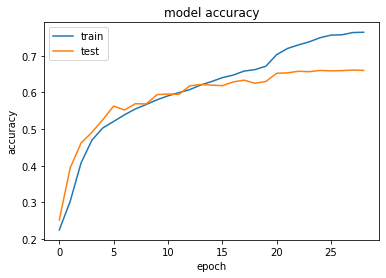

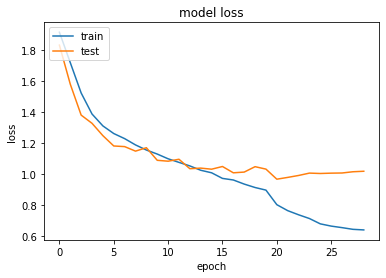

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Model Evaluation
train_score = model.evaluate(xtrain, ytrain, verbose=0)
print("Train score is ",train_score)
test_score = model.evaluate(xtest, ytest, verbose=0)
print("Test score is ",test_score)


Train score is  [0.4371616840362549, 0.8386917114257812]
Test score is  [1.0199192762374878, 0.6602117419242859]
